In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from collections import Counter

In [2]:
#@title Path to the source lines and target lines.
sPath = "sources.txt"  #@param {type:"string"}
tPath = "targets.txt"  #@param {type:"string"}

## Build the source and target distributions

In [3]:
def build_distribution(data):
  # Read data and store it in a list.
  with open(data) as file:
    clean_sentences = [' '.join(s.split()) for s in file]
  
  # Build a dict of unique sentences storing indexes to the original list.
  sentence_dict = {}
  for i, sentence in enumerate(clean_sentences):
    sentence_dict[sentence] = sentence_dict.get(sentence, [])
    sentence_dict[sentence].append(i)
      
  return sentence_dict, clean_sentences


source_distro, sources = build_distribution(sPath)
target_distro, targets = build_distribution(tPath)

## Compute the entropy for each sentence on both sides

In [4]:
def get_entropies(distro, pairs):
  entropies = {}

  for sentence, indices in distro.items():
    # Build a distribution for the current sentence, based on the targets.
    distribution = Counter([pairs[i] for i in indices])
    num_elements = len(indices)

    # Calculate entropy.
    entropy = 0
    for frequency in distribution.values():
      probability = frequency / num_elements
      entropy += probability * math.log(probability, 2)
    
    entropies[sentence] = -entropy

  return entropies


source_entropies = get_entropies(source_distro, targets)
target_entropies = get_entropies(target_distro, sources)

## Filter our data and save it

In [5]:
source_file = open('filtered_sources.txt', 'w')
target_file = open('filtered_targets.txt', 'w')

threshold = 1.1
for source, target in zip(sources, targets):
  # Here we can put whatever combination of the entropy thresholds.
  if source_entropies[source] < threshold and target_entropies[target] < threshold:
    source_file.write(source + '\n')
    target_file.write(target + '\n')

source_file.close()
target_file.close()

## Let's see the highest entropy sources and targets

In [6]:
def sort(entropies):
  sorted_dict = sorted(entropies.items(), key=lambda kv: kv[1])
  sorted_dict.reverse()
  return [utt[0] + ' | ' + str(utt[1]) for utt in sorted_dict]

print('\n'.join(sort(source_entropies)[:10]))
print('================================')
print('\n'.join(sort(target_entropies)[:10]))

yes. | 8.657932933415811
a | 8.327333336688609
yes, | 7.8741306391079755
no. | 7.51446418770985
what? | 7.124476314143311
no, | 7.124380981728205
why? | 7.034136268293366
well? | 6.914968135747496
what do you mean? | 6.485847547543662
what is it? | 6.358232304452302
yes. | 8.725892828727503
a | 8.366195994697977
yes, | 7.992098966105329
no. | 7.566115986566673
no, | 7.271774098575829
what? | 7.160963010181677
why? | 7.05176806358049
well? | 6.760688427027237
what do you mean? | 6.574318230493817
what is it? | 6.200709935866526


## Let's visualize the entropy distribution

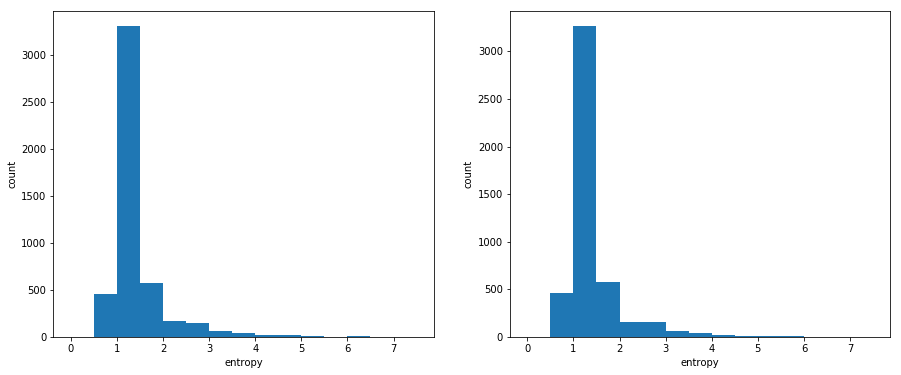

In [7]:
def visu(data, plot):
  # Since most of our entropies are zero we will exclude them.
  data = np.array(list(data.values()))
  data = data[np.nonzero(data)]

  bins = np.arange(0, 8, 0.5)
  plot.hist(data, bins=bins)
  plot.set_xlabel('entropy')
  plot.set_ylabel('count')

# Plot on the left is source data, and on the right target data.
fig, (plt1, plt2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
visu(source_entropies, plt1)
visu(target_entropies, plt2)

## Let's see the correlation between entropy and frequency
The red curve is the average entropy.

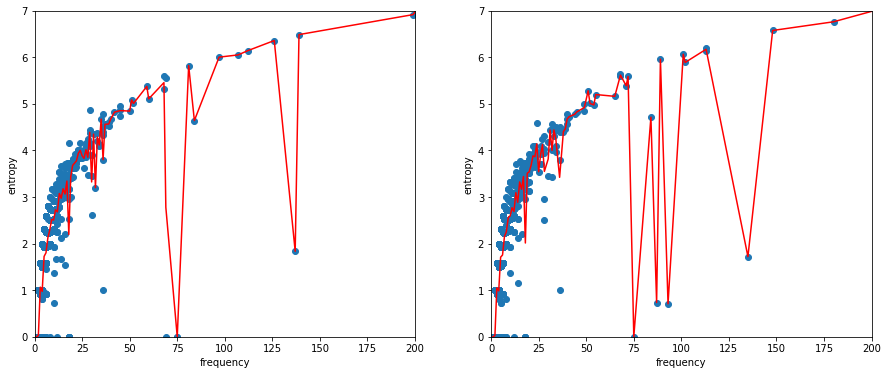

In [13]:
def visu(entropies_dict, data, plot):
  entropies = np.array(list(entropies_dict.values()))
  frequencies = np.array(list(Counter(data).values()))

  # Zoom in on the interesting part.
  plot.axis([0, 200, 0, 7])
  plot.scatter(frequencies, entropies)
  plot.set_xlabel('frequency')
  plot.set_ylabel('entropy')

  # Plot the average entropy for each frequency on the same graph.
  freq_entropies = {}
  frequencies = Counter(data)

  for sentence, entropy in entropies_dict.items():
    key = frequencies[sentence]
    freq_entropies[key] = freq_entropies.get(key, [])
    freq_entropies[key].append(entropy)

  # Sort the two lists according to frequency.
  avg_entropies = [sum(e) / len(e) for e in freq_entropies.values()]
  freq_entropy = dict(zip(list(freq_entropies.keys()), avg_entropies))
  sorted_dict = sorted(freq_entropy.items(), key=lambda kv: kv[0])
  
  plot.plot(np.array([x[0] for x in sorted_dict]), np.array([x[1] for x in sorted_dict]), color='red')

# Plot on the left is source data, and on the right target data.
fig, (plt1, plt2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
visu(source_entropies, sources, plt1)
visu(target_entropies, targets, plt2)

## Let's see the correlation between entropy and sentence length
The red dots is the average entropy.

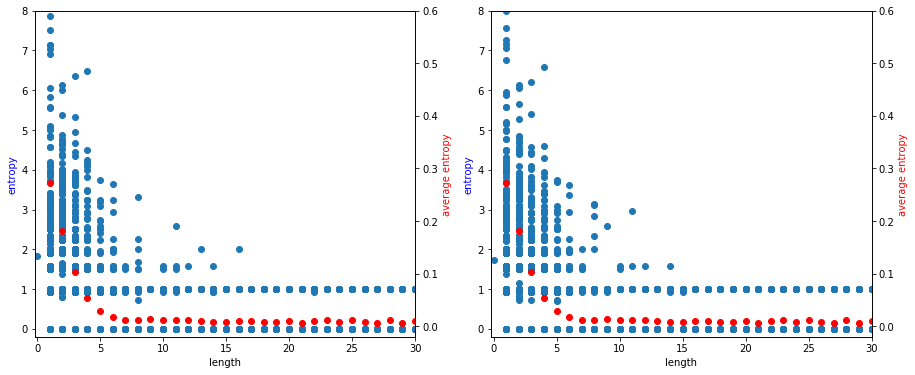

In [9]:
def visu(entropies_dict, plot):
    entropies = np.array(list(entropies_dict.values()))
    lengths = np.array([len(sentence.split()) for sentence in entropies_dict])

    # Zoom in on the interesting part.
    plot.axis([-0.2, 30, -0.2, 8])
    plot.scatter(lengths, entropies)
    plot.set_xlabel('length')
    plot.set_ylabel('entropy', color='blue')

    # Plot the average entropy for each sentence length on the same graph.
    length_entropies = {}
    for sentence, entropy in source_entropies.items():
      key = len(sentence.split())
      length_entropies[key] = length_entropies.get(key, [])
      length_entropies[key].append(entropy)
    
    # Sort the two lists according to sentence length.
    avg_entropies = [sum(e) / len(e) for e in length_entropies.values()]
    length_entropy = dict(zip(list(length_entropies.keys()), avg_entropies))
    sorted_dict = sorted(length_entropy.items(), key=lambda kv: kv[0])

    plot2 = plot.twinx()
    plot2.axis([-0.2, 30, -0.02, 0.6])
    plot2.set_ylabel('average entropy', color='red')
    plot2.scatter(np.array([x[0] for x in sorted_dict]), np.array([x[1] for x in sorted_dict]), color='red')

# Plot on the left is source data, and on the right target data.
fig, (plt1, plt2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
visu(source_entropies, plt1)
visu(target_entropies, plt2)

# Plotting everything in 3D

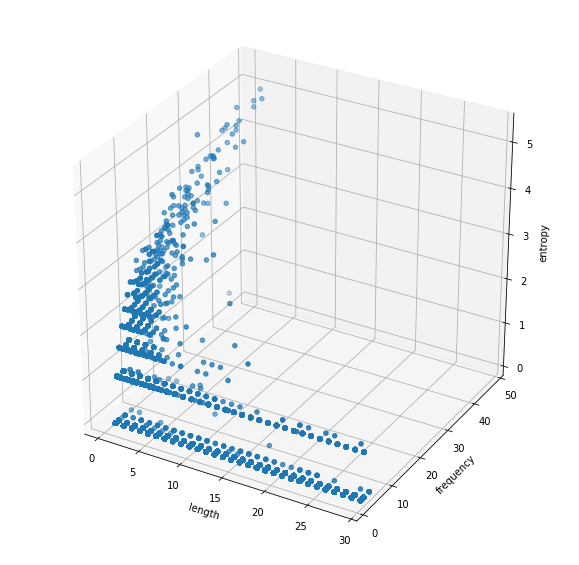

In [10]:
# Uncomment if you want interactive graph.
#%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d, Axes3D

entropies = np.array(list(source_entropies.values()))
lengths = np.array([float(len(sentence.split())) for sentence in source_entropies])
frequencies = np.array(list(Counter(sources).values()), dtype=float)

# Clip outliers.
lengths[lengths>30] = np.nan
frequencies[frequencies>50] = np.nan

fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(lengths, frequencies, entropies)
ax.set_xlim3d(-1, 30)
ax.set_ylim3d(-1, 50)
ax.set_zlim3d(-0.1, 5.5)
ax.set_xlabel('length')
ax.set_ylabel('frequency')
ax.set_zlabel('entropy')

plt.show()